In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.transform import Rotation
from tqdm import tqdm

In [2]:
original_df = pd.read_hdf(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000.h5")
original_df.columns = original_df.columns.droplevel(0)
main_df = pd.read_hdf(r"J:\Alja Podgornik\Multimaze arena\Cohort 1_June 2020\all_videos\processed\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000.h5")
main_df.columns = main_df.columns.droplevel(0)
df = main_df
# df.head()

In [3]:
# pd.options.mode.chained_assignment = None  # default='warn'

center = df['center']

for bodypart in df.columns.levels[0]:
    for axis in df.columns.levels[1][1:]:
        df.loc[:, (bodypart, axis)] = df.loc[:, (bodypart, axis)] - center.loc[:, axis]
        
centered = df.copy(deep=True)

In [4]:
rotated = pd.DataFrame(index=df.index, columns=df.columns)
angles = np.arctan2(df[('tail_base', 'y')], df['tail_base', 'x'])
# angles = np.where(angles<0, angles+2*np.pi, angles)

for bodypart in tqdm(df.columns.levels[0]):
    bp_df = df.loc[:, bodypart]
    bp_x = bp_df['x']
    bp_y = bp_df['y']
    bp_likelihood = bp_df['likelihood']
    cos = np.cos(angles)
    sin = np.sin(angles)
    for axis in bp_df.columns:
        if axis == 'x':
            rotated.loc[:, (bodypart, axis)] = (bp_x * cos) + (bp_y * sin)
        elif axis == 'y':
            rotated.loc[:, (bodypart, axis)] = (bp_y * cos) - (bp_x * sin)
        elif axis == 'likelihood':
            rotated.loc[:, (bodypart, axis)] = bp_likelihood

df = rotated
rotated = df.copy(deep=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.30it/s]


In [5]:
df = df.drop(columns=['paw_f_left', 'paw_f_right', 'paw_h_left', 'paw_h_right', 'tail_tip', 'tail_mid'], level=0)
high_likelihood = df.loc[:, df.columns.get_level_values(1) == 'likelihood'] > 0.7
high_likelihood = df.loc[high_likelihood.all(axis=1), :]
high_likelihood = high_likelihood.drop(columns='likelihood', level=1)

In [6]:
print(len(high_likelihood))

14412


In [7]:
skeleton = [['snout', 'left_ear'], ['snout', 'right_ear'], ['right_ear', 'left_ear'], ['left_ear', 'left_side'],
           ['right_ear', 'right_side'], ['right_side', 'tail_base'], ['left_side', 'tail_base'], ['center', 'left_ear'],
            ['center', 'right_ear'], ['center', 'right_side'], ['left_side', 'center']]

In [8]:
def plotter(to_plot, skeleton, indexes, plot_original_df=False, original_df=None, lim_min=-800, lim_max=800, limits=True):
    plt.figure(figsize=(15,5))
    indexcounter=1
    for i in indexes:
        
        plt.subplot(1,4,indexcounter)
        
        for bp in df.columns.get_level_values(0):
            
            plt.scatter(x=to_plot.loc[i, (bp, 'x')], y=to_plot.loc[i, (bp, 'y')], cmap='jet', )
            if plot_original_df:
                plt.scatter(x=original_df.loc[i, (bp, 'x')], y=original_df.loc[i, (bp, 'y')], cmap='jet', marker='*')

        for bp_pair in skeleton:
            
            plt.plot([to_plot.loc[i, (bp_pair[0], 'x')], to_plot.loc[i, (bp_pair[1], 'x')]],
                    [to_plot.loc[i, (bp_pair[0], 'y')], to_plot.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)
            if plot_original_df:
                plt.plot([original_df.loc[i, (bp_pair[0], 'x')], original_df.loc[i, (bp_pair[1], 'x')]],
                    [original_df.loc[i, (bp_pair[0], 'y')], original_df.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)

        indexcounter +=1
        if limits:
            plt.xlim(lim_min, lim_max)
            plt.ylim(lim_min, lim_max)
#         plt.tick_params(
#             axis='both',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom=False,      # ticks along the bottom edge are off
#             top=False,         # ticks along the top edge are off
#             labelbottom=False) # labels along the bottom edge are off
        plt.title('frame no:' + str(i), fontsize=18)
    
    plt.tight_layout()
    plt.show()

[6.49976804e+01 1.87286387e+01 4.73371211e+00 2.82702202e+00
 2.54077163e+00 1.90666553e+00 1.77236995e+00 8.19342602e-01
 6.40474671e-01 5.77888063e-01 4.55434276e-01 1.53656933e-30
 2.09508914e-32 5.77469138e-34]


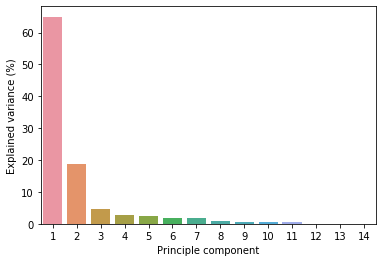

In [9]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, svd_solver='full')

pca_transformed = pca.fit_transform(high_likelihood)

expVar = pd.DataFrame(data=pca.explained_variance_ratio_*100, columns=['explained variance ratio'])
sns.barplot(data=expVar, y='explained variance ratio', x=list(range(1, len(expVar)+1)))
plt.ylabel('Explained variance (%)')
plt.xlabel('Principle component')
print(pca.explained_variance_ratio_*100)

In [10]:
pca_transformed_df = pd.DataFrame(data=pca_transformed, columns=list(range(1, len(expVar)+1)),
                               index=high_likelihood.index)
pca_transformed_df = pca_transformed_df.iloc[:, :11]
# pca_transformed_df

In [11]:
# from sklearn.cluster import KMeans

# km15 = KMeans(n_clusters=15, init='k-means++', n_init=100, max_iter=500, tol=0.0001,
#               precompute_distances=True, verbose=0, random_state=0, copy_x=True, n_jobs=-1, algorithm='auto')

# start_time = time.time()
# km15_l = km15.fit_predict(pca_transformed_df)
# print("km15 fit_predict in --- %s seconds ---" % (time.time() - start_time))

# np.save('onur_km15.npy', km15_l)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 14412 samples in 0.034s...
[t-SNE] Computed neighbors for 14412 samples in 2.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14412
[t-SNE] Computed conditional probabilities for sample 2000 / 14412
[t-SNE] Computed conditional probabilities for sample 3000 / 14412
[t-SNE] Computed conditional probabilities for sample 4000 / 14412
[t-SNE] Computed conditional probabilities for sample 5000 / 14412
[t-SNE] Computed conditional probabilities for sample 6000 / 14412
[t-SNE] Computed conditional probabilities for sample 7000 / 14412
[t-SNE] Computed conditional probabilities for sample 8000 / 14412
[t-SNE] Computed conditional probabilities for sample 9000 / 14412
[t-SNE] Computed conditional probabilities for sample 10000 / 14412
[t-SNE] Computed conditional probabilities for sample 11000 / 14412
[t-SNE] Computed conditional probabilities for sample 12000 / 14412
[t-SNE] Computed conditional probabilities for sa

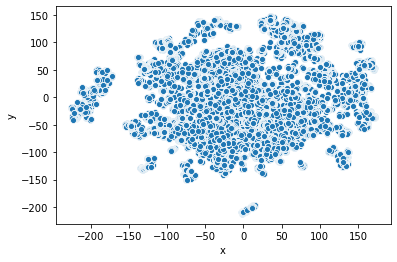

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=45, n_iter=100000, n_iter_without_progress=1000, init='random', n_jobs=-1,
           verbose=1, learning_rate=250, random_state=10)

start_time = time.time()
transformed = tsne.fit_transform(pca_transformed_df)
print("tsne fitted in --- %s seconds ---" % (time.time() - start_time))

transformed = pd.DataFrame(transformed, columns=['x','y'], index=pca_transformed_df.index)
sns.scatterplot(data=transformed, x='x', y='y')

In [13]:
from sklearn.neighbors import KernelDensity

In [44]:
transformed

,x,y
7,-121.160065,-1.330557
8,-121.569778,-1.484865
9,-121.538383,-1.544268
10,-121.555542,-2.559451
11,-121.370384,-2.632994
...,...,...
101268,-112.261108,62.085018
101403,-112.524330,45.850407
101475,-115.473717,45.359604
101490,155.699905,38.956524


In [14]:
kde = KernelDensity(kernel='gaussian', bandwidth=8)
start_time = time.time()
kde.fit(transformed)
print("fitted in --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
scores = kde.score_samples(transformed)
print("scored in --- %s seconds ---" % (time.time() - start_time))
kde_df = transformed.copy(deep=True)
kde_df['scores'] = np.exp(scores)

fitted in --- 0.009017229080200195 seconds ---
scored in --- 6.487154245376587 seconds ---


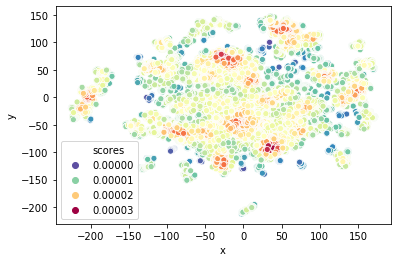

In [15]:
sns.scatterplot(data=kde_df, x='x', y='y', hue='scores', palette='Spectral_r')

In [45]:
x = np.linspace(transformed['x'].min(), transformed['x'].max(), 100)
y = np.linspace(transformed['y'].min(), transformed['y'].max(), 100)
X, Y = np.meshgrid(x, y)

xy = np.vstack([X.ravel(), Y.ravel()]).T

Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

In [17]:
print(transformed['x'].min())
np.min(Z)

-225.93903


5.880173526367495e-71

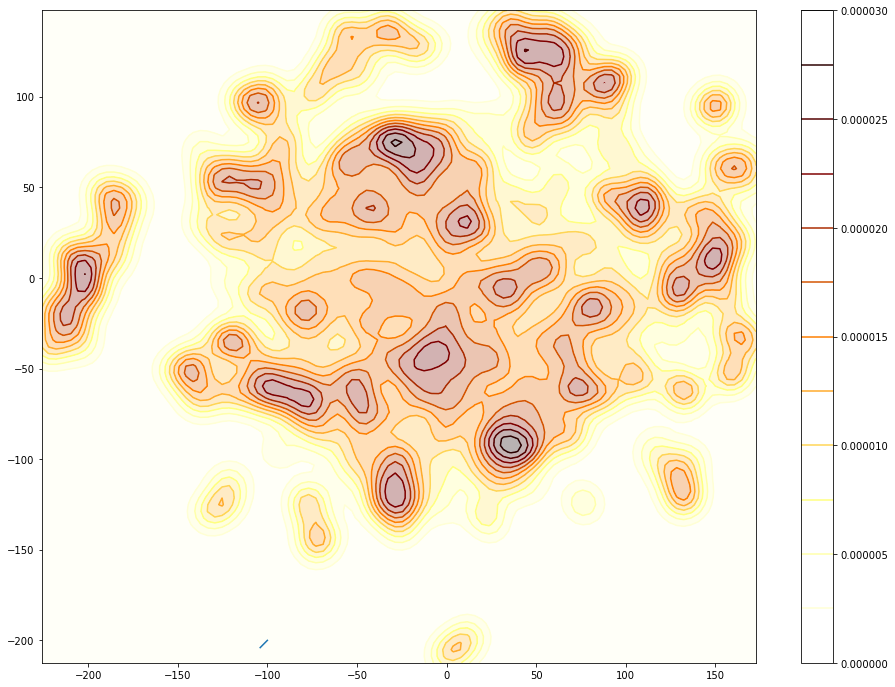

In [149]:
transformed2 = transformed.copy(deep=True)
transformed2['labels'] = np.load('onur_km15.npy')

plt.figure(figsize=(16,12))
plt.contourf(X, Y, Z, 12, cmap='afmhot_r', alpha=0.3)
plt.contour(X, Y, Z, 12, cmap='afmhot_r')
# sns.scatterplot(x=transformed2['x'], y=transformed2['y'], hue=transformed2['labels']+1 ,palette='deep', s=15)
plt.plot(np.arange(-100, -105, -1), np.arange(-200, -205, -1))
plt.colorbar()

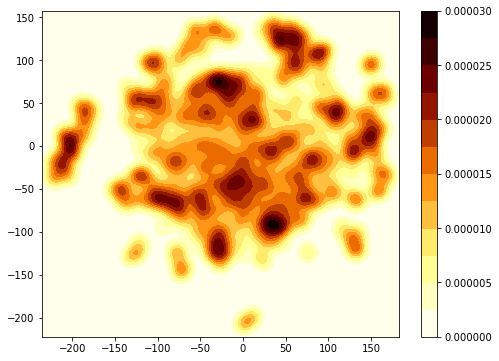

In [18]:
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z, 12, cmap='afmhot_r')
plt.colorbar()

In [19]:
from ipywidgets import interact
import pims

path_video = r"C:\Users\serce\Desktop\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000_labeled.mp4"
video = pims.Video(path_video)

In [20]:
@interact
def checkRegion(xmin:(X.min(), X.max()), xmax:(X.min(), X.max()), ymin:(Y.min(), Y.max()), ymax:(Y.min(), Y.max()),
                lev:(0,30,12)):
    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z, lev, cmap='afmhot_r')
    plt.colorbar()
    plt.axhline(ymin)
    plt.axhline(ymax)
    plt.axvline(xmin)
    plt.axvline(xmax)
    print("ymin, ymax, xmin, xmax =", (ymin, ymax, xmin, xmax))

interactive(children=(FloatSlider(value=-26.64012908935547, description='xmin', max=182.6587677001953, min=-23…

In [ ]:
ymin, ymax, xmin, xmax = (40.0, 55.0, -20.0, -10.0)

x_filtered = transformed[(transformed['x'] > xmin) & (transformed['x'] < xmax)]
y_filtered = x_filtered[(x_filtered['y'] > ymin) & (x_filtered['y'] < ymax)]
filtered_subset = y_filtered.sample(3)
# filtered_subset = y_filtered.loc[[4836, 19073, 44129], :]
print(y_filtered.index)
print(len(y_filtered), 'frames in total')
print(filtered_subset.index)
plotter(high_likelihood, skeleton, filtered_subset.index, lim_min=-115, lim_max=115)
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z, 12, cmap='afmhot_r')
plt.colorbar()
plt.scatter(transformed.loc[filtered_subset.index, 'x'], transformed.loc[filtered_subset.index, 'y'])
plt.axhline(ymin)
plt.axhline(ymax)
plt.axvline(xmin)
plt.axvline(xmax)

In [ ]:
folder = r"C:\Users\serce\Desktop\inspect"
region = 'region6'

for n, frame_no in enumerate(filtered_subset.index):
    frame = video[frame_no]
    plt.imsave(os.path.join(folder, region, str(n) + '_' + str(frame_no) + '.png'), arr=frame)

In [ ]:
Z.shape

(100, 100)

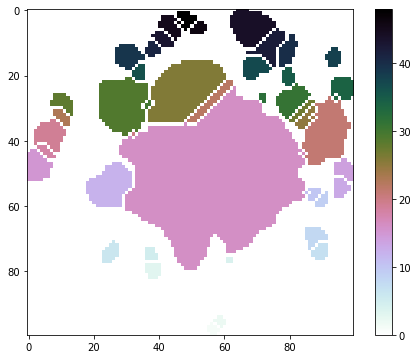

In [47]:
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image=Z
thresh = threshold_otsu(image)
binary = image > thresh

image=binary

distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False,
                            labels=image)

markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image, watershed_line=True)

plt.figure(figsize=(8,6))
plt.imshow(np.flipud(labels), cmap='cubehelix_r')
# sns.scatterplot(x=transformed2['x'], y=transformed2['y'], hue=transformed2['labels']+1, palette='deep')
plt.colorbar()
labels.shape

reshape labels?

In [ ]:
Z.reshape(-1).shape

In [ ]:
def plotter2(to_plot, skeleton, indexes, plot_original_df=False, original_df=None, lim_min=-800, lim_max=800, limits1=True,
            alignment=False, limits2=False):
    plt.figure(figsize=(12,4))
    indexcounter=1
    for i in indexes:
        
        plt.subplot(1,3,indexcounter)
        
        for bp in df.columns.get_level_values(0):
            
            plt.scatter(x=to_plot.loc[i, (bp, 'x')], y=to_plot.loc[i, (bp, 'y')], cmap='jet', )
            if plot_original_df:
                plt.scatter(x=original_df.loc[i, (bp, 'x')], y=original_df.loc[i, (bp, 'y')], cmap='jet', marker='*')

        for bp_pair in skeleton:
            
            plt.plot([to_plot.loc[i, (bp_pair[0], 'x')], to_plot.loc[i, (bp_pair[1], 'x')]],
                    [to_plot.loc[i, (bp_pair[0], 'y')], to_plot.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)
            if plot_original_df:
                plt.plot([original_df.loc[i, (bp_pair[0], 'x')], original_df.loc[i, (bp_pair[1], 'x')]],
                    [original_df.loc[i, (bp_pair[0], 'y')], original_df.loc[i, (bp_pair[1], 'y')]],
                    color = 'k', linestyle='-', linewidth=1)
        if alignment:
            
            plt.plot([0, to_plot.loc[i, ('tail_base', 'x')]],
                    [0, to_plot.loc[i, ('tail_base', 'y')]],
                    color = 'r', linestyle='--', linewidth=1)

        indexcounter +=1
        if limits1:
            plt.xlim(0, 1280)
            plt.ylim(0, 816)
        elif limits2:
            plt.xlim(-120, +120)
            plt.ylim(-120, +120)
#         plt.tick_params(
#             axis='both',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom=False,      # ticks along the bottom edge are off
#             top=False,         # ticks along the top edge are off
#             labelbottom=False) # labels along the bottom edge are off
#         plt.title('frame no:' + str(i), fontsize=18)
        plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
vis = high_likelihood.sample(3)
vis_rotated = original_df.loc[vis.index].copy(deep=True)

center = vis_rotated['center']

for bodypart in vis_rotated.columns.levels[0]:
    for axis in vis_rotated.columns.levels[1][1:]:
        vis_rotated.loc[:, (bodypart, axis)] = vis_rotated.loc[:, (bodypart, axis)] - center.loc[:, axis]

vis_orig = original_df.loc[vis.index].drop(columns=['paw_f_left', 'paw_f_right', 'paw_h_left', 'paw_h_right', 'tail_tip', 'tail_mid'], level=0)

plotter2(vis_orig, skeleton=skeleton, indexes=vis.index)
plotter2(vis_rotated, skeleton=skeleton, indexes=vis.index, limits1=False, limits2=True)
plotter2(vis, skeleton=skeleton, indexes=vis.index, limits1=False, alignment=True, limits2=True)

----------------------------------------

In [ ]:
100 - len(high_likelihood)/len(original_df)*100

In [ ]:
plt.style.use('seaborn')
# plt.rcParams.update({'fontsize': 14})
sns.set(font_scale=1.2)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.barplot(data=expVar, y='explained variance ratio', x=list(range(1, len(expVar)+1)))
plt.plot(expVar['cumulative'], ':.', label="Cumulative explained variance")
plt.ylabel('Explained variance (%)')
plt.xlabel('Principle component')
plt.legend()
plt.subplot(1, 2, 2)
sns.scatterplot(data=transformed, x='x', y='y')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.tight_layout()

In [ ]:
# plt.rcParams.keys()

plot = sns.scatterplot(data=kde_df, x='x', y='y', hue='scores', palette='Spectral_r')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()
plt.contourf(X, Y, Z, 12, cmap='afmhot_r')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar()

In [72]:
def crop_frame(frame, crop):
    """Generic function for cropping an image/frame."""
    r = crop

    return frame[int(r[1]):int(r[1] + r[3]), int(r[0]):int(r[0] + r[2])]

18720

In [120]:
import pims
import imageio as io
from tqdm import tqdm
import cv2

# import PIL
# from PIL import Image
# space = Image.open("C:/Users/serce/Desktop/temp.png")

short_video = pims.Video(r"C:\Users\serce\Desktop\chr8_day3DLC_resnet152_dlc_realApr6shuffle4_110000_labeled.mp4")
fps = 30
start_frame = fps*(10*60 + 6)
end_frame = fps*(10*60 + 30)
short_video = short_video[start_frame:end_frame]
# io.mimwrite(uri=r"C:\Users\serce\Desktop\sample_video.mp4", ims=short_video, fps=30)

# resized_space = space.resize((short_video.frame_shape[1], short_video.frame_shape[0]))
# plt.imshow(np.hstack((short_video[0], np.array(resized_space)[:,:,:3])))

In [86]:
try:
    print(transformed2.loc[start_frame+60])
except KeyError:
    print('asdf')

x         24.332268
y        -84.398872
labels     3.000000
Name: 18240, dtype: float64


In [94]:
transformed2.columns

Index(['x', 'y', 'labels'], dtype='object')

In [179]:
texted_vid = []
font = cv2.FONT_HERSHEY_SIMPLEX
roi = (425,0,1280-425,520)
cluster='LowP'
for n, frame in enumerate(tqdm(short_video)):
    try:
        cluster = int(transformed2.loc[start_frame+n, 'labels'])
    except KeyError:
        cluster = 'LowP'
    texted_frame = cv2.putText(frame.copy(), 'cluster: '+ str(cluster), (450, 100),
               font, 3, (0, 0, 255), 2, cv2.LINE_4, bottomLeftOrigin=False)
    texted_vid.append(crop_frame(texted_frame, roi))
    
io.mimwrite(uri=r"C:\Users\serce\Desktop\sample_video_texted_onur.mp4", ims=texted_vid, fps=30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:03<00:00, 180.98it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (855, 520) to (864, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [178]:
texted_vid = []
font = cv2.FONT_HERSHEY_SIMPLEX
roi = (425,0,1280-425,520)
cluster='LowP'
for n, frame in enumerate(tqdm(short_video)):
    try:
        cluster = int(transformed2.loc[start_frame+n, 'labels'])
    except KeyError:
        cluster = 'LowP'
    texted_frame = cv2.putText(frame.copy(),  'cluster: '+ str(cluster), (100, 100),
               font, 4, (0, 0, 255), 2, cv2.LINE_4, bottomLeftOrigin=False)
    texted_vid.append(texted_frame)
    
io.mimwrite(uri=r"C:\Users\serce\Desktop\sample_video_texted_onur_fullsize.mp4", ims=texted_vid, fps=30)

  0%|                                                                                                                                  | 0/720 [00:00<?, ?it/s]C:\Users\serce\Anaconda3\envs\bsclone\lib\site-packages\pims\pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:03<00:00, 181.36it/s]


In [175]:
myarray = np.array([])
for n, frame in enumerate(tqdm(short_video)):
    try:
        previous = transformed2.loc[start_frame+n-10:start_frame+n, ['x', 'y']]
    except (KeyError, IndexError):
        previous = 'LowP'
    
    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z, 12, cmap='afmhot_r', alpha=0.3)
    plt.contour(X, Y, Z, 12, cmap='afmhot_r')
    
    try:
        plt.plot(previous.iloc[-1,0], previous.iloc[-1,1])
        plt.annotate('here', xy=(previous.iloc[-1,0], previous.iloc[-1,1]),
                     xytext=(previous.iloc[-1,0]+25, previous.iloc[-1,1]+25), 
                     arrowprops=dict(facecolor='blue', shrink=0.05))
    except (TypeError, IndexError):
        plt.text(0, 0, 'Low P', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

        
    plt.tight_layout()
    plt.savefig(r"C:\Users\serce\Desktop\render"+"\\"+str(n)+".png")
    plt.close()
    
# io.mimwrite(uri=r"C:\Users\serce\Desktop\sample_video_texted_onur.mp4", ims=texted_vid, fps=30)

  0%|                                                                                                                                  | 0/720 [00:00<?, ?it/s]C:\Users\serce\Anaconda3\envs\bsclone\lib\site-packages\pims\pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [02:14<00:00,  5.37it/s]


In [176]:
makevideo = []
render = r"C:\Users\serce\Desktop\render"
for f in tqdm(os.listdir(render)):
    makevideo.append(io.imread(os.path.join(render, f)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:08<00:00, 86.13it/s]


In [177]:
io.mimwrite(uri=r"C:\Users\serce\Desktop\sample_video_space_onur_2.mp4", ims=makevideo, fps=30)

In [173]:
np.append(np.array([]), np.nan)

array([nan])